In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Librerie

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import os
import io
import time

path_to_file = '/content/drive/My Drive/Colab Notebooks/DeepLearningExamples/ita.txt'

# Preprocessing

**gestire meglio i dataset input e output del decoder:** https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html


In [3]:
# converte i caratteri unicode in ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # crea spazi intorno ai caratteri ?.!,'
  # https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,'])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # rimpiazza tutto con spazi eccetto (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,']+", " ", w)
  w = w.strip()

  # aggiunge i token start e end così che il modello capisca quando iniziare e finire a predirre
  w = '<start> ' + w + ' <end>'
  return w

def create_dataset(path, num_examples):
  lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]] for l in lines[:num_examples]]
  return zip(*word_pairs)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
  targ_lang, inp_lang = create_dataset(path, num_examples)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [62]:
num_examples = 50000
#input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples) # ita -> eng
target_tensor, input_tensor, targ_lang, inp_lang = load_dataset(path_to_file, num_examples) # eng -> ita
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

# calcolo la lunghezza massima degli input
max_length_inp, max_length_targ = input_tensor.shape[1], target_tensor.shape[1]
print("Max len input: {}, Max len target: {}".format(max_length_inp, max_length_targ))

Max len input: 11, Max len target: 21


In [8]:
en_sentence = "There is no answer to your question."
en_sentence = preprocess_sentence(en_sentence)
print(en_sentence)
en_sentence = targ_lang.texts_to_sequences([en_sentence])
print(en_sentence)

it_sentence = "Non c'è nessuna risposta per la tua domanda."
it_sentence = preprocess_sentence(it_sentence)
print(it_sentence)
it_sentence = inp_lang.texts_to_sequences([it_sentence])
print(it_sentence)

<start> there is no answer to your question . <end>
[[1, 76, 13, 71, 328, 23, 41, 4056, 3, 2]]
<start> non c ' e nessuna risposta per la tua domanda . <end>
[[1, 9, 113, 14, 4, 2468, 899, 40, 13, 147, 4302, 3, 2]]


In [63]:
# training e validation con split 80-20
input_train, input_val, target_train, target_val = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=0)

print(len(input_train), len(target_train), len(input_val), len(target_val))

40000 40000 10000 10000


# Seq2Seq
Tutorial 1: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

Tutorial 2: https://towardsdatascience.com/word-level-english-to-marathi-neural-machine-translation-using-seq2seq-encoder-decoder-lstm-model-1a913f2dc4a7

![testo alternativo](https://github.com/tensorflow/nmt/raw/master/nmt/g3doc/img/seq2seq.jpg)

In [10]:
target_train_input = target_train[:, :-1] # tolgo l'ultima colonna, ovvero quella con <end>
target_train_output = target_train[:, 1:] # tolgo la prima colonna, ovvero quella con <start>

target_val_input = target_val[:, :-1] # tolgo l'ultima colonna, ovvero quella con <end>
target_val_output = target_val[:, 1:] # tolgo la prima colonna, ovvero quella con <start>

print('Eesempio Input decoder: {}\nEesempio Output decoder: {}'.format(target_train_input[0], target_train_output[0]))

Eesempio Input decoder: [  1  47   7 328   3   2   0   0   0   0]
Eesempio Output decoder: [ 47   7 328   3   2   0   0   0   0   0]


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, None, 100)    939900      input_45[0][0]                   
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, None, 100)    411300      input_46[0][0]                   
___________________________________________________________________________________________

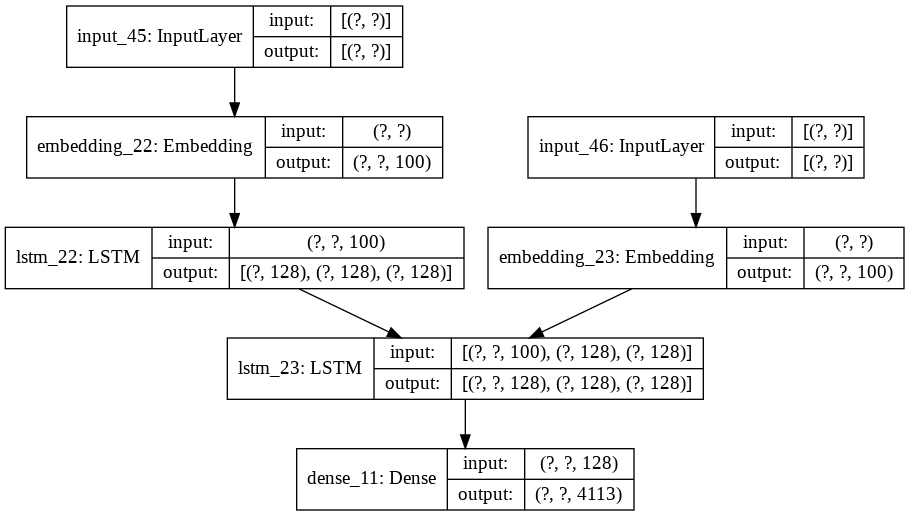

In [ ]:
emb_size = 100
rnn_units = 128

encoder_inputs = Input(shape=(None,))
encoder_embed = Embedding(vocab_inp_size, emb_size) (encoder_inputs)
encoder_lstm = LSTM(rnn_units, return_state=True)
_, state_h, state_c = encoder_lstm (encoder_embed)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
decoder_embed_layer = Embedding(vocab_tar_size, emb_size)
decoder_embed = decoder_embed_layer (decoder_inputs)
decoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ =  decoder_lstm (decoder_embed, initial_state=encoder_states)

decoder_dense = Dense(vocab_tar_size, activation='softmax')
decoder_outputs = decoder_dense (decoder_outputs)

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
tf.random.set_seed(0)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history = model.fit([input_train, target_train_input], 
                    target_train_output,
                    batch_size=64,
                    epochs=50,
                    validation_data=([input_val, target_val_input], target_val_output)
                    )

# batch_size = 64
# dataset_train = tf.data.Dataset.from_tensor_slices(((input_train, target_train_input), target_train_output)).shuffle(len(input_train)).batch(batch_size, drop_remainder=True)
# dataset_val = tf.data.Dataset.from_tensor_slices(((input_val, target_val_input), target_val_output)).shuffle(len(input_val)).batch(batch_size, drop_remainder=True)

# history = model.fit(dataset_train,
#                     epochs=50,
#                     validation_data=dataset_val
#                     )

Epoch 1/50
625/625 [==============================] - 17s 27ms/step - loss: 2.3261 - accuracy: 0.6312 - val_loss: 1.7811 - val_accuracy: 0.6948
Epoch 2/50
625/625 [==============================] - 16s 25ms/step - loss: 1.6269 - accuracy: 0.7141 - val_loss: 1.4877 - val_accuracy: 0.7375
Epoch 3/50
625/625 [==============================] - 16s 26ms/step - loss: 1.3447 - accuracy: 0.7577 - val_loss: 1.2787 - val_accuracy: 0.7686
Epoch 4/50
625/625 [==============================] - 16s 26ms/step - loss: 1.1723 - accuracy: 0.7806 - val_loss: 1.1481 - val_accuracy: 0.7876
Epoch 5/50
625/625 [==============================] - 17s 27ms/step - loss: 1.0443 - accuracy: 0.7997 - val_loss: 1.0486 - val_accuracy: 0.8030
Epoch 6/50
625/625 [==============================] - 16s 26ms/step - loss: 0.9419 - accuracy: 0.8143 - val_loss: 0.9749 - val_accuracy: 0.8131
Epoch 7/50
625/625 [==============================] - 16s 26ms/step - loss: 0.8570 - accuracy: 0.8273 - val_loss: 0.9110 - val_accuracy:

In [ ]:
encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states, name="Encoder_model_inferenza")
encoder_model.summary()

decoder_state_input_h = Input(shape=(rnn_units,))
decoder_state_input_c = Input(shape=(rnn_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embed_inf = decoder_embed_layer (decoder_inputs)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm (decoder_embed_inf, initial_state=decoder_states_inputs)
decoder_states_inf = [state_h_inf, state_c_inf]
decoder_outputs_inf = decoder_dense (decoder_outputs_inf)

decoder_model = tf.keras.models.Model([decoder_inputs] + decoder_states_inputs,
                                      [decoder_outputs_inf] + decoder_states_inf,
                                      name="Decoder_model_inferenza")

decoder_model.summary()

Model: "Encoder_model_inferenza"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_22 (Embedding)     (None, None, 100)         939900    
_________________________________________________________________
lstm_22 (LSTM)               [(None, 128), (None, 128) 117248    
Total params: 1,057,148
Trainable params: 1,057,148
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder_model_inferenza"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, None)]       0                                            
_________________________________

In [ ]:
def evaluate(inputs):

  inputs = preprocess_sentence(inputs)
  inputs = inp_lang.texts_to_sequences([inputs])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=max_length_inp, padding='post')
  inputs = tf.convert_to_tensor(inputs)
  # print(inputs)

  result = ''
  states_value = encoder_model(inputs)
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ - 1):
    output_tokens, dec_h, dec_c = decoder_model([dec_input] + states_value)
    predicted_id = np.argmax(output_tokens[0, -1, :])
    word = targ_lang.index_word[predicted_id]

    if word == '<end>':
      return result[:-1]

    result += word + ' '
    # come prossimo input uso la parola appena predetta
    dec_input = tf.expand_dims([predicted_id], 0)
    # come prossimi stati uso quelli in uscita dal decoder
    states_value = [dec_h, dec_c]
    
  return result

it_sentence = "Come stai?"
evaluate(it_sentence)

'how are you ?'

In [ ]:
def test_dataset(path, num_examples, lang='it'):
  lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[w for w in l.split('\t')[:2]] for l in lines[:num_examples]]
  eng_test, it_test = zip(*word_pairs)
  if lang == 'it':
    db = list(it_test)
  else:
    db = list(eng_test)
  for seq in db:
    decoded_sentence = evaluate(seq)
    print()
    print('Input sentence:', seq)
    print('Decoded sentence:', decoded_sentence)

test_dataset(path_to_file, 100, lang='it')


Input sentence: Ciao!
Decoded sentence: hi .

Input sentence: Corri!
Decoded sentence: get out !

Input sentence: Corra!
Decoded sentence: run !

Input sentence: Correte!
Decoded sentence: stand up !

Input sentence: Chi?
Decoded sentence: who ?

Input sentence: Wow!
Decoded sentence: wow !

Input sentence: Salta!
Decoded sentence: jump !

Input sentence: Salti!
Decoded sentence: jump !

Input sentence: Saltate!
Decoded sentence: jump !

Input sentence: Salta.
Decoded sentence: jump .

Input sentence: Salti.
Decoded sentence: jump .

Input sentence: Saltate.
Decoded sentence: jump .

Input sentence: Fermati!
Decoded sentence: stop !

Input sentence: Fermatevi!
Decoded sentence: stop !

Input sentence: Stop!
Decoded sentence: do it !

Input sentence: Si fermi!
Decoded sentence: stop that !

Input sentence: Aspetta!
Decoded sentence: wait !

Input sentence: Aspettate!
Decoded sentence: hang on .

Input sentence: Aspetti!
Decoded sentence: hang on .

Input sentence: Aspetta.
Decoded sent

# Seq2Seq with Attention

**Tutorial**: https://www.tensorflow.org/tutorials/text/nmt_with_attention

Spiegazione attention: https://blog.floydhub.com/attention-mechanism/

Spiegazione attention 2: https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html

Bahdanau attention: https://arxiv.org/pdf/1409.0473.pdf

Luong Attention: https://arxiv.org/abs/1508.04025


![testo alternativo](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)


In [71]:
batch_size = 64
steps_per_epoch = len(input_train)//batch_size
emb_size = 256
rnn_units = 1024
dataset_train = tf.data.Dataset.from_tensor_slices((input_train, target_train)).shuffle(len(input_train)).batch(batch_size, drop_remainder=True)
dataset_val = tf.data.Dataset.from_tensor_slices((input_val, target_val)).shuffle(len(input_val)).batch(batch_size, drop_remainder=True)

In [73]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, hidden, features):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    score = self.V(tf.nn.tanh(self.W1(hidden_with_time_axis) + self.W2(features)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(self.enc_units, return_sequences=True, return_state=True)

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state_h, state_c = self.lstm(x, initial_state=hidden)
    return output, state_h

  def initialize_hidden_state(self):
    init_c = tf.zeros([self.batch_sz, self.enc_units])
    init_h = tf.zeros([self.batch_sz, self.enc_units])
    return [init_h, init_c]

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True)
    self.fc = Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state_h, state_c = self.lstm(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state_h, attention_weights

example_input_batch, example_target_batch = next(iter(dataset_train))

encoder = Encoder(vocab_inp_size, emb_size, rnn_units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

decoder = Decoder(vocab_tar_size, emb_size, rnn_units, batch_size)
sample_decoder_output, _, _ = decoder(tf.random.uniform((batch_size, 1)), sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Encoder output shape: (batch size, sequence length, units) (64, 11, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)
Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 11, 1)
Decoder output shape: (batch_size, vocab size) (64, 9399)


In [74]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# https://stackoverflow.com/questions/47057361/how-do-i-mask-a-loss-function-in-keras-with-the-tensorflow-backend
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_h = encoder(inp, enc_hidden)
    dec_h = enc_h
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * batch_size, 1)

    # Teacher forcing
    for t in range(1, targ.shape[1]):
      predictions, dec_h, _ = decoder(dec_input, dec_h, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

for epoch in range(10):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset_train.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.2803
Epoch 1 Batch 100 Loss 1.1429
Epoch 1 Batch 200 Loss 1.0087
Epoch 1 Batch 300 Loss 0.9999
Epoch 1 Batch 400 Loss 0.9280
Epoch 1 Batch 500 Loss 0.8390
Epoch 1 Batch 600 Loss 0.7410
Epoch 1 Loss 0.9940
Time taken for 1 epoch 253.0089817047119 sec

Epoch 2 Batch 0 Loss 0.7314
Epoch 2 Batch 100 Loss 0.6997
Epoch 2 Batch 200 Loss 0.6541
Epoch 2 Batch 300 Loss 0.6681
Epoch 2 Batch 400 Loss 0.6326
Epoch 2 Batch 500 Loss 0.5485
Epoch 2 Batch 600 Loss 0.4949
Epoch 2 Loss 0.6222
Time taken for 1 epoch 223.65556287765503 sec

Epoch 3 Batch 0 Loss 0.4728
Epoch 3 Batch 100 Loss 0.4234
Epoch 3 Batch 200 Loss 0.4297
Epoch 3 Batch 300 Loss 0.3956
Epoch 3 Batch 400 Loss 0.3799
Epoch 3 Batch 500 Loss 0.4169
Epoch 3 Batch 600 Loss 0.4299
Epoch 3 Loss 0.4163
Time taken for 1 epoch 223.627135515213 sec

Epoch 4 Batch 0 Loss 0.2807
Epoch 4 Batch 100 Loss 0.2951
Epoch 4 Batch 200 Loss 0.2789
Epoch 4 Batch 300 Loss 0.2912
Epoch 4 Batch 400 Loss 0.3263
Epoch 4 Batch 500 Loss 0.2513


In [67]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)
  inputs = inp_lang.texts_to_sequences([sentence])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=max_length_inp, padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, rnn_units)), tf.zeros((1, rnn_units))]
  enc_out, enc_h = encoder(inputs, hidden)
  dec_h = enc_h
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_h, attention_weights = decoder(dec_input, dec_h, enc_out)
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
  fontdict = {'fontsize': 14}
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hi ! how are you ? <end>
Predicted translation: ciao ! come stai ? <end> 


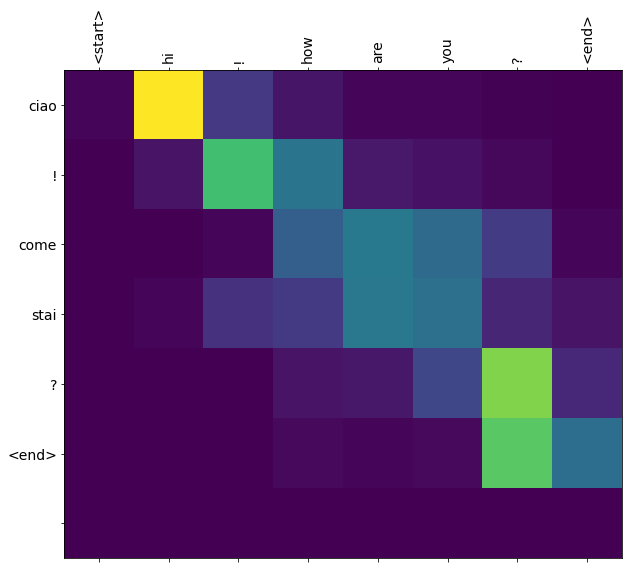

In [76]:
en_sentence = "hi! how are you?"
translate(en_sentence)